# imports

In [1]:
%matplotlib inline
import codecs
import logging

import numpy as np
from word2vec.word2vecReader import Word2Vec
from preprocessing import preprocess_tweet

from nltk import word_tokenize

from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

from lasagne import layers
from lasagne.updates import nesterov_momentum
from lasagne.nonlinearities import tanh, softmax
from nolearn.lasagne import NeuralNet

import matplotlib.pyplot as plt

import sys

Using gpu device 0: GeForce GT 650M (CNMeM is disabled)


# Load the corpus and the model

In [2]:
f = codecs.open('../data/positive-all', 'r', 'utf-8')
positive = {l.strip() for l in f}
f.close()

f = codecs.open('../data/negative-all', 'r', 'utf-8')
negative = {l.strip() for l in f}
f.close()

f = codecs.open('../data/neutral-all', 'r', 'utf-8')
neutral = {l.strip() for l in f}
f.close()

print 'Number of positives = %d' % len(positive)
print 'Number of negatives = %d' % len(negative)
print 'Number of neutrals  = %d' % len(neutral)

Number of positives = 7331
Number of negatives = 9372
Number of neutrals  = 10724


In [3]:
model_path = '../models/word2vec_twitter_model.bin'
w2v = Word2Vec.load_word2vec_format(model_path, binary=True)

print "Loaded the model with layer size: %d and %d vocabulary size." % (w2v.layer1_size, len(w2v.vocab))

Loaded the model with layer size: 400 and 3039345 vocabulary size.


# Let's check word frequencies in each class

In [4]:
import preprocessing
reload(preprocessing)

positive_counts = dict()
negative_counts = dict()
neutral_counts  = dict()

for sent in positive:
    for w in preprocessing.preprocess_tweet(sent):
        if w not in positive_counts: positive_counts[w] = 0
        positive_counts[w] += 1

for sent in negative:
    for w in preprocessing.preprocess_tweet(sent):
        if w not in negative_counts: negative_counts[w] = 0
        negative_counts[w] += 1

for sent in neutral:
    for w in preprocessing.preprocess_tweet(sent):
        if w not in neutral_counts: neutral_counts[w] = 0
        neutral_counts[w] += 1

print 'Vocab size for positives: %d' % (len(positive_counts))
print 'Vocab size for negatives: %d' % (len(negative_counts))
print 'Vocab size for neutrals : %d' % (len(neutral_counts))

N = 50
print 'Top %d positive words:' % N
for w in sorted(positive_counts.keys(), key=positive_counts.get, reverse=True)[:N]:
    print '\t%s : %d' % (w, positive_counts[w])

print 'Top %d neutral words:' % N
for w in sorted(neutral_counts.keys(), key=neutral_counts.get, reverse=True)[:N]:
    print '\t%s : %d' % (w, neutral_counts[w])

print 'Top %d negative words:' % N
for w in sorted(negative_counts.keys(), key=negative_counts.get, reverse=True)[:N]:
    print '\t%s : %d' % (w, negative_counts[w])

Vocab size for positives: 8776
Vocab size for negatives: 10529
Vocab size for neutrals : 12070
Top 50 positive words:
	|||HASHTAG||| : 8972
	|||MENTION||| : 5478
	! : 4627
	i : 2183
	|||DIGIT||| : 1570
	you : 1210
	ipad : 912
	it : 909
	my : 859
	google : 777
	apple : 768
	not : 709
	? : 678
	up : 575
	store : 557
	so : 543
	me : 515
	thanks : 497
	just : 487
	iphone : 456
	new : 454
	quot : 453
	go : 440
	app : 403
	out : 385
	thank : 382
	great : 376
	amp : 367
	your : 359
	lineup : 358
	see : 323
	all : 323
	coachella : 311
	get : 308
	now : 303
	will : 303
	we : 296
	line : 295
	flight : 269
	but : 264
	austin : 262
	time : 261
	one : 252
	love : 251
	like : 250
	going : 246
	got : 244
	good : 236
	they : 234
	can : 227
Top 50 neutral words:
	|||HASHTAG||| : 13264
	|||MENTION||| : 8631
	|||DIGIT||| : 3155
	? : 2625
	google : 2216
	i : 1766
	! : 1627
	you : 1327
	apple : 1240
	ipad : 1091
	car : 1069
	quot : 992
	cars : 929
	it : 926
	not : 898
	store : 897
	new : 834
	my : 819
	sel

# Build a training set using only the word2vec features

In [5]:
positive_features = np.zeros((len(positive), w2v.layer1_size), dtype=np.float32)
negative_features = np.zeros((len(negative), w2v.layer1_size), dtype=np.float32)
neutral_features  = np.zeros((len(neutral) , w2v.layer1_size), dtype=np.float32)

# the word2vec model is so big so we don't really need to normalise
# the tweets before passing them over to the model, just tokenizing...

for i, sentence in enumerate(positive):
    sent_vec = w2v.get_sentence_vec(word_tokenize(sentence))
    positive_features[i,] = sent_vec

for i, sentence in enumerate(negative):
    sent_vec = w2v.get_sentence_vec(word_tokenize(sentence))
    negative_features[i,] = sent_vec

for i, sentence in enumerate(neutral):
    sent_vec = w2v.get_sentence_vec(word_tokenize(sentence))
    neutral_features[i,] = sent_vec

del w2v # we're finished with it for now

# Split the dataset into train/test

In [6]:
# we'll ignore the imbalance of the classes for now and see what happens
# choose 500 samples from each class to be included in the test set

num_test_samples_per_class = 500

pos_train, pos_test = train_test_split(positive_features, test_size=num_test_samples_per_class, random_state=22)
neg_train, neg_test = train_test_split(negative_features, test_size=num_test_samples_per_class, random_state=22)
neu_train, neu_test = train_test_split(neutral_features , test_size=num_test_samples_per_class, random_state=22)

X_train = np.vstack((
    pos_train,
    neg_train,
    neu_train
))
X_test  = np.vstack((
    pos_test,
    neg_test,
    neu_test
))
Y_train = np.hstack((
    np.ones((pos_train.shape[0]), dtype=np.float32),
    np.ones((neg_train.shape[0]), dtype=np.float32) * -1,
    np.zeros((neu_train.shape[0]), dtype=np.float32)
))
Y_test = np.hstack((
    np.ones((pos_test.shape[0]), dtype=np.float32),
    np.ones((neg_test.shape[0]), dtype=np.float32) * -1,
    np.zeros((neu_test.shape[0]), dtype=np.float32)
))

# shuffle 'em
X_train, Y_train = shuffle(X_train, Y_train, random_state=111)
X_test , Y_test  = shuffle(X_test , Y_test , random_state=111)

# train a classifier on this dataset

In [7]:
model = LogisticRegression(C=1e5, class_weight='auto', random_state=33)
scores = cross_val_score(model, X_train, Y_train, cv=3, verbose=1, n_jobs=8)
print "Accuracy: %0.5f [%0.5f - %0.5f]" % (scores.mean(), scores.mean()-scores.std() * 2, scores.mean()+scores.std() * 2)

model.fit(X_train, Y_train)

[Parallel(n_jobs=8)]: Done   1 jobs       | elapsed:    9.6s
[Parallel(n_jobs=8)]: Done   3 out of   3 | elapsed:   10.1s finished


Accuracy: 0.76152 [0.75851 - 0.76454]


LogisticRegression(C=100000.0, class_weight='auto', dual=False,
          fit_intercept=True, intercept_scaling=1, penalty='l2',
          random_state=33, tol=0.0001)

# Evaluate the classifier

             precision    recall  f1-score   support

       -1.0       0.83      0.89      0.86       500
        0.0       0.71      0.79      0.75       500
        1.0       0.77      0.64      0.70       500

avg / total       0.77      0.77      0.77      1500

[[444  31  25]
 [ 39 393  68]
 [ 52 129 319]]


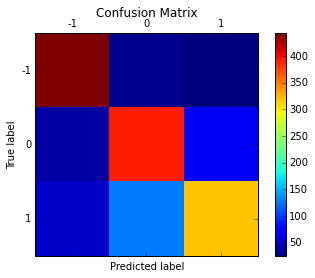

In [6]:
Y_pred = model.predict(X_test)
print classification_report(Y_test, Y_pred)

cm = confusion_matrix(Y_test, Y_pred)

print cm

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
fig.colorbar(cax)

ax.set_xticklabels(['']+['-1', '0', '1'])
ax.set_yticklabels(['']+['-1', '0', '1'])

plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Let's see the effect of PCA!

In [7]:
pca = PCA(n_components=300, whiten=True)
pca.fit(X_train)

X_transformed = pca.transform(X_train)

model = LogisticRegression(C=1e5, class_weight='auto', random_state=33)
scores = cross_val_score(model, X_transformed, Y_train, cv=3, verbose=1)
print "Accuracy: %0.5f [%0.5f - %0.5f]" % (scores.mean(), scores.mean()-scores.std() * 2, scores.mean()+scores.std() * 2)

model.fit(X_transformed, Y_train)

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.2s finished


Accuracy: 0.75905 [0.75811 - 0.76000]


LogisticRegression(C=100000.0, class_weight='auto', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', penalty='l2', random_state=33,
          solver='liblinear', tol=0.0001, verbose=0)

             precision    recall  f1-score   support

       -1.0       0.84      0.90      0.86       500
        0.0       0.70      0.77      0.73       500
        1.0       0.77      0.63      0.70       500

avg / total       0.77      0.77      0.76      1500

[[448  30  22]
 [ 42 387  71]
 [ 46 138 316]]


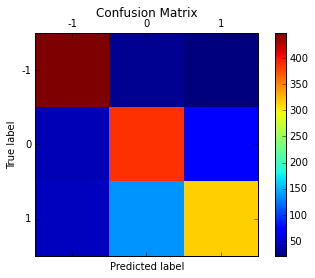

In [8]:
Y_pred = model.predict(pca.transform(X_test))
print classification_report(Y_test, Y_pred)

cm = confusion_matrix(Y_test, Y_pred)

print cm

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
fig.colorbar(cax)

ax.set_xticklabels(['']+['-1', '0', '1'])
ax.set_yticklabels(['']+['-1', '0', '1'])

plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# It's not helping.

# Let's see what a normal neural net does on the W2V features

In [13]:
# first implement a class to cache the best model and
# prevent overfitting
class EarlyStopping(object):
    def __init__(self, patience):
        self.patience = patience
        self.best_valid = np.inf
        self.best_valid_epoch = 0
        self.best_weights = None

    def __call__(self, nn, train_history):
        current_valid = train_history[-1]['valid_loss']
        current_epoch = train_history[-1]['epoch']
        if current_valid < self.best_valid:
            self.best_valid = current_valid
            self.best_valid_epoch = current_epoch
            self.best_weights = nn.get_all_params_values()
        elif self.best_valid_epoch + self.patience < current_epoch:
            print "Early stopping."
            print "Best valid loss was {:.6f} at epoch {}.".format(
                self.best_valid, self.best_valid_epoch)
            sys.stdout.flush()
            nn.load_params_from(self.best_weights)
            raise StopIteration()

# another helper class to adjust the learning rate and the momentum
class AdjustVariable(object):
    def __init__(self, name, stop, decrement=0.0001, increment=None):
        self.name = name
        self.stop = stop
        self.decrement = decrement
        self.increment = increment

    def __call__(self, nn, train_history):
        epoch = train_history[-1]['epoch']
        if self.increment:
            new_value = min(getattr(nn, self.name) + self.increment, self.stop)
        else:
            new_value = max(getattr(nn, self.name) - self.decrement, self.stop)
        nn.__dict__[self.name] = np.cast['float32'](new_value)
            
model = NeuralNet(
        layers=[
        ('input', layers.InputLayer),
        ('hidden1', layers.DenseLayer),
        ('dropout1', layers.DropoutLayer),
        ('hidden2', layers.DenseLayer),
        ('dropout2', layers.DropoutLayer),
        ('output', layers.DenseLayer),
    ],
    input_shape=(None, 400),
    hidden1_num_units=1000, dropout1_p=0.5,
    hidden2_num_units=1000, dropout2_p=0.5,
    
    output_nonlinearity=tanh,
    output_num_units=1,

    # optimization method:
    regression=True,
    update=nesterov_momentum,
    update_learning_rate=0.01,
    update_momentum=0.9,
    
    on_epoch_finished=[
        AdjustVariable('update_learning_rate', stop=0.0001, decrement=0.00001),
        AdjustVariable('update_momentum',      stop=0.999,  increment=0.0001),
        EarlyStopping(patience=100)
    ],
    max_epochs=1000,
    eval_size=0.1,
    verbose=1
)

model.fit(np.asarray(X_train, dtype=np.float32), np.asarray(Y_train, dtype=np.float32))

# Neural Network with 1403001 learnable parameters

## Layer information

  #  name        size
---  --------  ------
  0  input        400
  1  hidden1     1000
  2  dropout1    1000
  3  hidden2     1000
  4  dropout2    1000
  5  output         1

  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       0.49380       0.40578      1.21692  1.96s
      2       0.38043       0.34664      1.09748  1.55s
      3       0.34009       0.31964      1.06398  1.89s
      4       0.31969       0.30434      1.05043  1.54s
      5       0.30566       0.30284      1.00931  1.53s
      6       0.29810       0.29219      1.02025  1.53s
      7       0.28983       0.28547      1.01526  1.52s
      8       0.28221       0.29149      0.96817  1.53s
      9       0.27866       0.28924      0.96344  1.53s
     10       0.27459       0.27711      0.99090  1.53s
     11       0.26981       0.27150      0.99379  1.85s
     12       0.26798  

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x116999090>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x116983fd0>,
     custom_score=None, dropout1_p=0.5, dropout2_p=0.5,
     hidden1_num_units=1000, hidden2_num_units=1000,
     input_shape=(None, 400),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('hidden1', <class 'lasagne.layers.dense.DenseLayer'>), ('dropout1', <class 'lasagne.layers.noise.DropoutLayer'>), ('hidden2', <class 'lasagne.layers.dense.DenseLayer'>), ('dropout2', <class 'lasagne.layers.noise.DropoutLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=1000, more_params={},
     objective=<function objective at 0x1169849b0>,
     objective_loss_function=<function squared_error at 0x11696a140>,
     on_epoch_finished=[<__main__.AdjustVariable object at 0x175ce2490>, <__main__.AdjustVariable object at 0x175cdf7d0>, <__main__.Earl

# Evaluate the NN

             precision    recall  f1-score   support

       -1.0       0.92      0.84      0.88       500
        0.0       0.63      0.84      0.72       500
        1.0       0.81      0.61      0.70       500

avg / total       0.79      0.76      0.77      1500

[[421  68  11]
 [ 22 419  59]
 [ 16 178 306]]


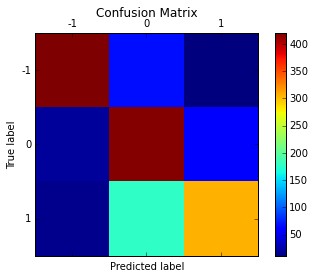

In [31]:
Y_pred = model.predict(np.asarray(X_test, dtype=np.float32))

# let's threshold the continuous values to get the classes
pos = Y_pred >= .33
neg = Y_pred <= -0.33
neu = np.logical_and(Y_pred < 0.33, Y_pred > -0.33)
Y_pred[pos] = 1
Y_pred[neg] = -1
Y_pred[neu] = 0

print classification_report(Y_test, Y_pred)

cm = confusion_matrix(Y_test, Y_pred)

print cm

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
fig.colorbar(cax)

ax.set_xticklabels(['']+['-1', '0', '1'])
ax.set_yticklabels(['']+['-1', '0', '1'])

plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

             precision    recall  f1-score   support

       -1.0       0.91      0.86      0.88       500
        0.0       0.68      0.68      0.68       500
        1.0       0.72      0.75      0.73       500

avg / total       0.77      0.76      0.77      1500

[[430  52  18]
 [ 29 340 131]
 [ 16 107 377]]


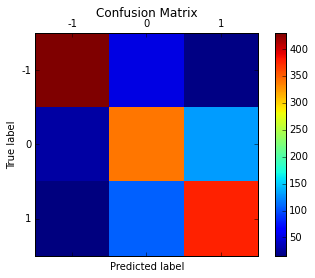

In [14]:
Y_pred = model.predict(np.asarray(X_test, dtype=np.float32))

# let's threshold the continuous values to get the classes
pos = Y_pred >= .33
neg = Y_pred <= -0.33
neu = np.logical_and(Y_pred < 0.33, Y_pred > -0.33)
Y_pred[pos] = 1
Y_pred[neg] = -1
Y_pred[neu] = 0

print classification_report(Y_test, Y_pred)

cm = confusion_matrix(Y_test, Y_pred)

print cm

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
fig.colorbar(cax)

ax.set_xticklabels(['']+['-1', '0', '1'])
ax.set_yticklabels(['']+['-1', '0', '1'])

plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## The biggest problem is between Positive Vs. Neutral. Let's try to find useful distinguishers for these two classes.

# See how good (or bad) the linguistic features that we have

In [7]:
import features
reload(features)

positive_features = np.zeros((len(positive), features.NUM_LINGUISTIC_FEATURES), dtype=np.float32)
negative_features = np.zeros((len(negative), features.NUM_LINGUISTIC_FEATURES), dtype=np.float32)
neutral_features  = np.zeros((len(neutral) , features.NUM_LINGUISTIC_FEATURES), dtype=np.float32)

for i, sentence in enumerate(positive):
    sent_vec = features.get_linguistic_features(sentence)
    positive_features[i,] = sent_vec

for i, sentence in enumerate(negative):
    sent_vec = features.get_linguistic_features(sentence)
    negative_features[i,] = sent_vec

for i, sentence in enumerate(neutral):
    sent_vec = features.get_linguistic_features(sentence)
    neutral_features[i,] = sent_vec

# we'll ignore the imbalance of the classes for now and see what happens
# choose 500 samples from each class to be included in the test set

num_test_samples_per_class = 500

pos_train, pos_test = train_test_split(positive_features, test_size=num_test_samples_per_class, random_state=22)
neg_train, neg_test = train_test_split(negative_features, test_size=num_test_samples_per_class, random_state=22)
neu_train, neu_test = train_test_split(neutral_features , test_size=num_test_samples_per_class, random_state=22)

X_train = np.vstack((
    pos_train,
    neg_train,
    neu_train
))
X_test  = np.vstack((
    pos_test,
    neg_test,
    neu_test
))
Y_train = np.hstack((
    np.ones((pos_train.shape[0]), dtype=np.float32),
    np.ones((neg_train.shape[0]), dtype=np.float32) * -1,
    np.zeros((neu_train.shape[0]), dtype=np.float32)
))
Y_test = np.hstack((
    np.ones((pos_test.shape[0]), dtype=np.float32),
    np.ones((neg_test.shape[0]), dtype=np.float32) * -1,
    np.zeros((neu_test.shape[0]), dtype=np.float32)
))

# shuffle 'em
X_train, Y_train = shuffle(X_train, Y_train, random_state=111)
X_test , Y_test  = shuffle(X_test , Y_test , random_state=111)

# Train LR

In [8]:
model = LogisticRegression(C=1e5, class_weight='auto', random_state=33)
scores = cross_val_score(model, X_train, Y_train, cv=3, verbose=1, n_jobs=8)
print "Accuracy: %0.5f [%0.5f - %0.5f]" % (scores.mean(), scores.mean()-scores.std() * 2, scores.mean()+scores.std() * 2)

model.fit(X_train, Y_train)

Accuracy: 0.62159 [0.60780 - 0.63538]


[Parallel(n_jobs=8)]: Done   1 jobs       | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   3 out of   3 | elapsed:    0.1s finished


LogisticRegression(C=100000.0, class_weight='auto', dual=False,
          fit_intercept=True, intercept_scaling=1, penalty='l2',
          random_state=33, tol=0.0001)

[[ 0.35346987  4.92481448  1.80200111  2.88740596  1.34519168 -0.06794115
   1.20213894 -4.38018904]
 [-2.13637061 -3.40506267 -2.38370639 -1.82043459  0.25270369 -2.41349426
  -3.46977753  0.79135405]
 [ 2.92176862 -1.57157761  1.50862341  1.11264888 -2.41054806  3.26814909
   1.841855    3.13502001]]
             precision    recall  f1-score   support

       -1.0       0.74      0.62      0.68       500
        0.0       0.53      0.66      0.59       500
        1.0       0.61      0.55      0.58       500

avg / total       0.63      0.61      0.61      1500

[[311 123  66]
 [ 57 331 112]
 [ 53 171 276]]


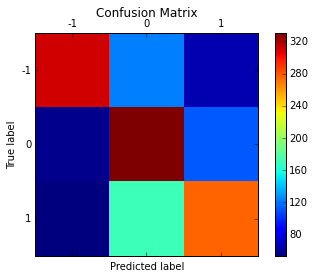

In [34]:
print model.coef_

Y_pred = model.predict(X_test)
print classification_report(Y_test, Y_pred)

cm = confusion_matrix(Y_test, Y_pred)

print cm

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
fig.colorbar(cax)

ax.set_xticklabels(['']+['-1', '0', '1'])
ax.set_yticklabels(['']+['-1', '0', '1'])

plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Okay so these are much worse than word2vec. Let's combine them together.

In [38]:
model_path = '../models/word2vec_twitter_model.bin'
w2v = Word2Vec.load_word2vec_format(model_path, binary=True)

import features
reload(features)

num_features = w2v.layer1_size + features.NUM_LINGUISTIC_FEATURES
positive_features = np.zeros((len(positive), num_features), dtype=np.float32)
negative_features = np.zeros((len(negative), num_features), dtype=np.float32)
neutral_features  = np.zeros((len(neutral) , num_features), dtype=np.float32)

for i, sentence in enumerate(positive):
    sent_vec = features.get_features(w2v, sentence)
    positive_features[i,] = sent_vec

for i, sentence in enumerate(negative):
    sent_vec = features.get_features(w2v, sentence)
    negative_features[i,] = sent_vec

for i, sentence in enumerate(neutral):
    sent_vec = features.get_features(w2v, sentence)
    neutral_features[i,] = sent_vec

del w2v
    
num_test_samples_per_class = 500

pos_train, pos_test = train_test_split(positive_features, test_size=num_test_samples_per_class, random_state=22)
neg_train, neg_test = train_test_split(negative_features, test_size=num_test_samples_per_class, random_state=22)
neu_train, neu_test = train_test_split(neutral_features , test_size=num_test_samples_per_class, random_state=22)

X_train = np.vstack((
    pos_train,
    neg_train,
    neu_train
))
X_test  = np.vstack((
    pos_test,
    neg_test,
    neu_test
))
Y_train = np.hstack((
    np.ones((pos_train.shape[0]), dtype=np.float32),
    np.ones((neg_train.shape[0]), dtype=np.float32) * -1,
    np.zeros((neu_train.shape[0]), dtype=np.float32)
))
Y_test = np.hstack((
    np.ones((pos_test.shape[0]), dtype=np.float32),
    np.ones((neg_test.shape[0]), dtype=np.float32) * -1,
    np.zeros((neu_test.shape[0]), dtype=np.float32)
))

# shuffle 'em
X_train, Y_train = shuffle(X_train, Y_train, random_state=111)
X_test , Y_test  = shuffle(X_test , Y_test , random_state=111)

In [39]:
model = LogisticRegression(C=1e5, class_weight='auto', random_state=33)
scores = cross_val_score(model, X_train, Y_train, cv=3, verbose=1, n_jobs=8)
print "Accuracy: %0.5f [%0.5f - %0.5f]" % (scores.mean(), scores.mean()-scores.std() * 2, scores.mean()+scores.std() * 2)

model.fit(X_train, Y_train)

[Parallel(n_jobs=8)]: Done   1 out of   3 | elapsed:   16.0s remaining:   32.0s
[Parallel(n_jobs=8)]: Done   3 out of   3 | elapsed:   16.3s finished


Accuracy: 0.76723 [0.76123 - 0.77323]


LogisticRegression(C=100000.0, class_weight='auto', dual=False,
          fit_intercept=True, intercept_scaling=1, penalty='l2',
          random_state=33, tol=0.0001)

             precision    recall  f1-score   support

       -1.0       0.84      0.88      0.86       500
        0.0       0.71      0.79      0.75       500
        1.0       0.78      0.66      0.71       500

avg / total       0.78      0.77      0.77      1500

[[441  35  24]
 [ 37 393  70]
 [ 46 126 328]]


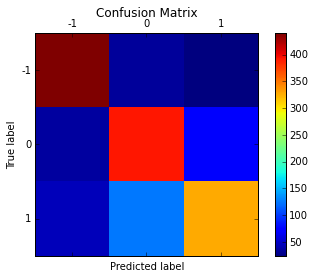

In [40]:
Y_pred = model.predict(X_test)
print classification_report(Y_test, Y_pred)

cm = confusion_matrix(Y_test, Y_pred)

print cm

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
fig.colorbar(cax)

ax.set_xticklabels(['']+['-1', '0', '1'])
ax.set_yticklabels(['']+['-1', '0', '1'])

plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Very little improvement. Let's train a model on the w2v features, and then use the output of this model as a linguistic feature.

In [18]:
w2v_outputs = model.predict(X_train)

# convert the outputs to 3 indicator (i.e. binary) features
mlb = MultiLabelBinarizer()
w2v_outputs = mlb.fit_transform([(x,) for x in w2v_outputs.tolist()])
print list(mlb.classes_)

[-1.0, 0.0, 1.0]


In [23]:
# load the linguistic features again

import features
reload(features)

positive_features = np.zeros((len(positive), features.NUM_LINGUISTIC_FEATURES), dtype=np.float32)
negative_features = np.zeros((len(negative), features.NUM_LINGUISTIC_FEATURES), dtype=np.float32)
neutral_features  = np.zeros((len(neutral) , features.NUM_LINGUISTIC_FEATURES), dtype=np.float32)

for i, sentence in enumerate(positive):
    sent_vec = features.get_linguistic_features(sentence)
    positive_features[i,] = sent_vec

for i, sentence in enumerate(negative):
    sent_vec = features.get_linguistic_features(sentence)
    negative_features[i,] = sent_vec

for i, sentence in enumerate(neutral):
    sent_vec = features.get_linguistic_features(sentence)
    neutral_features[i,] = sent_vec

# we'll ignore the imbalance of the classes for now and see what happens
# choose 500 samples from each class to be included in the test set

num_test_samples_per_class = 500

pos_train, pos_test = train_test_split(positive_features, test_size=num_test_samples_per_class, random_state=22)
neg_train, neg_test = train_test_split(negative_features, test_size=num_test_samples_per_class, random_state=22)
neu_train, neu_test = train_test_split(neutral_features , test_size=num_test_samples_per_class, random_state=22)

X_train = np.vstack((
    pos_train,
    neg_train,
    neu_train
))
X_test  = np.vstack((
    pos_test,
    neg_test,
    neu_test
))
Y_train = np.hstack((
    np.ones((pos_train.shape[0]), dtype=np.float32),
    np.ones((neg_train.shape[0]), dtype=np.float32) * -1,
    np.zeros((neu_train.shape[0]), dtype=np.float32)
))
Y_test = np.hstack((
    np.ones((pos_test.shape[0]), dtype=np.float32),
    np.ones((neg_test.shape[0]), dtype=np.float32) * -1,
    np.zeros((neu_test.shape[0]), dtype=np.float32)
))

# shuffle 'em
X_train, Y_train = shuffle(X_train, Y_train, random_state=111)
X_test , Y_test  = shuffle(X_test , Y_test , random_state=111)

In [20]:
# now combine the features and train a new classifier
X_train = np.hstack((
    w2v_outputs,
    X_train
))

ling_model = LogisticRegression(C=1e5, class_weight='auto', random_state=33)
scores = cross_val_score(ling_model, X_train, Y_train, cv=3, verbose=1)
print "Accuracy: %0.5f [%0.5f - %0.5f]" % (scores.mean(), scores.mean()-scores.std() * 2, scores.mean()+scores.std() * 2)

ling_model.fit(X_train, Y_train)
print ling_model.coef_

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s finished


Accuracy: 0.77722 [0.77457 - 0.77987]
[[ 1.78308727 -2.00017066 -1.51003745 -0.12711376  2.66382888  0.83223089
   1.41265682  0.54149745 -0.37233413  1.36643276 -2.02640973]
 [-1.28674621  1.80233702 -0.26957343 -1.33392601 -1.62424827 -1.19637774
  -0.86351365  0.62487347 -1.45411957 -1.84409244 -0.2899234 ]
 [-1.78057058 -0.89058757  1.02719014  1.81030889 -0.7555225   0.90475212
   0.57236135 -1.62974088  1.93892389  0.64970067  1.8247693 ]]
